In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [3]:
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path):
    cols = ['id','device_id', 'timestamp', 'battery_level', 'network_status', 'screen_brightness', 'screen_on', 'timezone', 'country_code']
    # sorted by [device_id, timestamp]
    df = load_df(path, cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [4]:
df = prepare('datasets/samples.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11503813 entries, 0 to 11503812
Data columns (total 9 columns):
id                   uint32
device_id            uint16
timestamp            datetime64[ns]
battery_level        uint8
network_status       object
screen_brightness    int64
screen_on            uint8
timezone             object
country_code         object
dtypes: datetime64[ns](1), int64(1), object(3), uint16(1), uint32(1), uint8(2)
memory usage: 526.6+ MB


In [5]:
df.head()

,id,device_id,timestamp,battery_level,network_status,screen_brightness,screen_on,timezone,country_code
0,447027,1,2017-10-15 18:36:46,99,lte,-1,1,america/chicago,us
1,447015,1,2017-10-15 18:41:54,98,lte,-1,1,america/chicago,us
2,447012,1,2017-10-15 18:46:54,97,lte,-1,1,america/chicago,us
3,447011,1,2017-10-15 18:50:35,96,lte,-1,1,america/chicago,us
4,446225,1,2017-10-15 18:54:14,95,lte,-1,1,america/chicago,us


In [6]:
df['change'] = df.battery_level - df.battery_level.shift()
df.loc[df.device_id != df.device_id.shift(), 'change'] = None
df.head()

,id,device_id,timestamp,battery_level,network_status,screen_brightness,screen_on,timezone,country_code,change
0,447027,1,2017-10-15 18:36:46,99,lte,-1,1,america/chicago,us,NaN
1,447015,1,2017-10-15 18:41:54,98,lte,-1,1,america/chicago,us,-1.0
2,447012,1,2017-10-15 18:46:54,97,lte,-1,1,america/chicago,us,-1.0
3,447011,1,2017-10-15 18:50:35,96,lte,-1,1,america/chicago,us,-1.0
4,446225,1,2017-10-15 18:54:14,95,lte,-1,1,america/chicago,us,-1.0


In [7]:
def show_hist(s, bins, title, end=None, start=0, step=1, ylabel='# Samples', color='#66b3ff'):
    s.hist(bins=bins, color=color, edgecolor='k', linewidth=.5, figsize=(12,6))
    if (end != None):
        plt.xticks(np.arange(start, end, step))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(title + '.png')
    plt.show()

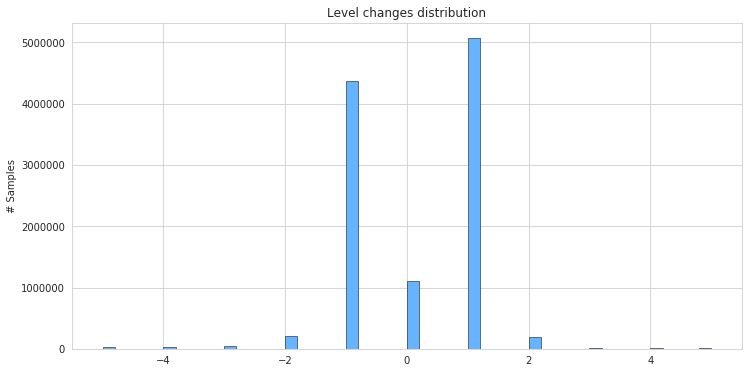

In [8]:
interval = 5

gl = df[(df['change'] >= -interval) & (df['change'] <= interval)]

show_hist(gl['change'], 50, 'Level changes distribution')

In [9]:
df['boundary'] = (abs(df['change']) <= 2).astype(np.int)

In [10]:
periodNum = 0
threshold = 2
previousDeviceId = 0
previousDirection = 1 # either -1, 1

def nextPeriod() :
    global periodNum
    periodNum = periodNum + 1
    return periodNum

def resetPeriods() :
    global periodNum
    periodNum = 0
    
sign = lambda x: x and (1, -1)[x < 0]

def calculatePeriod(deviceId, change) : 
    
    hardCodedDirection = -1
    
    currentDeviceId = deviceId
    directionChanged = False
    global previousDeviceId 
    global previousDirection
    
    if( pd.isnull(change)) : #if first sample of device, need to initialize directions
        previousDirection = hardCodedDirection
        currentDirection = previousDirection
    else :
        currentDirection = sign(change)
        
    if (currentDirection != 0) : # either -1, 1 = the battery changed. if 0, then we keep the previousDirection
        if (currentDirection != previousDirection) : # the battery changed direction, else nothing changes
            directionChanged = True 
            previousDirection = currentDirection
    
    if((deviceId == previousDeviceId) #same device
       and (change >= -threshold) and (change <= threshold) #within threshold
       and (not directionChanged)) : #direction not changed
        return periodNum
    else :
        previousDeviceId = deviceId
        return nextPeriod()

resetPeriods()

df['period'] = 1
df['period'] = df.apply(lambda row : calculatePeriod(row['device_id'], row['change']), axis = 1)

In [14]:
#df['change_acc'] = df['change'].cumsum()
#df.loc[df.period != df.period.shift(), 'change_acc'] = None
df['change'].iloc[0] = 0.0 #initialize first value for future cumsums
df.loc[df.device_id != df.device_id.shift(), 'change'] = 0.0
df['change_acc'] = df.groupby('period')['change'].apply(lambda x:x.cumsum()-x.iat[0])


In [15]:
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
df['time_diff'].iloc[0] = 0.0 #initialize first value for future cumsums
df['time_acc'] = df.groupby('period')['time_diff'].apply(lambda x:x.cumsum()-x.iat[0])


In [16]:
df.loc[df.period != df.period.shift(), 'time_diff'] = 0.0
df.head(100)

,id,device_id,timestamp,battery_level,network_status,screen_brightness,screen_on,timezone,country_code,change,boundary,period,change_acc,time_diff,time_acc
0,447027,1,2017-10-15 18:36:46,99,lte,-1,1,america/chicago,us,0.0,0,1,0.0,0.0,0.0
1,447015,1,2017-10-15 18:41:54,98,lte,-1,1,america/chicago,us,-1.0,1,1,-1.0,308.0,308.0
2,447012,1,2017-10-15 18:46:54,97,lte,-1,1,america/chicago,us,-1.0,1,1,-2.0,300.0,608.0
3,447011,1,2017-10-15 18:50:35,96,lte,-1,1,america/chicago,us,-1.0,1,1,-3.0,221.0,829.0
4,446225,1,2017-10-15 18:54:14,95,lte,-1,1,america/chicago,us,-1.0,1,1,-4.0,219.0,1048.0
5,447009,1,2017-10-15 18:54:14,95,lte,-1,1,america/chicago,us,0.0,1,1,-4.0,0.0,1048.0
6,446218,1,2017-10-15 18:57:54,94,lte,-1,1,america/chicago,us,-1.0,1,1,-5.0,220.0,1268.0
7,446217,1,2017-10-15 19:02:47,93,lte,-1,1,america/chicago,us,-1.0,1,1,-6.0,293.0,1561.0
8,443535,1,2017-10-15 19:11:41,91,lte,-1,1,america/chicago,us,-2.0,1,1,-8.0,534.0,2095.0
9,443533,1,2017-10-15 19:21:25,89,lte,-1,1,america/chicago,us,-2.0,1,1,-10.0,584.0,2679.0


In [17]:
#df.loc[df['period'] == 981931]

In [18]:
df.to_parquet('datasets/periods.parquet', compression='none') 